In [101]:
from models import *
from plot_max_model import *
from plot_avg_model import *

# Final Report - Modeling the Urban Head Island Effect in NYC

## Introduction 

The goal of this project is to model the urban heat island effect. Specifically, this project attempts to oberve the effect of density, tree canopy, building height and proximity to parks on the temperature in New York City throughout the day. Prior studies have tried to model the phenomenon through surface temperatures computed from satellite imagery. This project differs in that NYC captures hourly temperatures of multiple locations and hence using this data, it may be possible to get a more accurate picture of the effects of these variables on temperature. 

Prior work (Yin et al. 2018) that has investigated the effects of these factors on the urban summer temperatures through causal inference use regressions with techniques similar to those found in econometrics. In order to encode the causal assumptions for this report to allow for causal interpretation of coefficients, a Pearlean causal diagram is provided below.

<img src="misc/causal_graph.png" width="500">

### Data
The data for this project was sourced from multiple datasets that were obtained from the NYC OpenData platform. Specifically, the datasets of Hyperlocal Temperature Monitoring, Park Properties, Building Footprints and lastly the 2015 Tree Census were used.

The NYC Parks Department, Mayor’s Office of Resilience and NYC Department of Health and Mental Hygiene has measured the daily temperatures of neighborhoods with the highest mortality risk during two summers of 2018 and 2019 from 475 different locations in the city. The temperatures are provided on an hourly basis for each location.

<img src="misc/map_2.png" height="100">
Above is a few of the sensor locations.

Using this latitude and longitude of location of a sensor, it is possible to create metrics for various factors that contribute to the UHI effect. I created the following variables:
* **num_trees_15m:** the count of trees in a 15 meter radius around a sensor. This could be seen as a measure of tree canopy around the sensor. 
* **min_distance_park:** The minimum distance to a park.
* **num_build500:** the number of buildings within a 50m radius of a sensor.
* **mean_fa_ratio** the mean floor area ratio of buildings within the 50m radius of a sensor. The floor-area ratio, is the height of the building divided by the area of the building. It becomes a metric for the height of the building in proportion to the amount of space the building takes up on the street.

Below is an image of the average hourly temperatures stratified by the different variables above. As seen below, it seems that **num_trees15** has the most clear seperation in the highest temperatures of the day:

<img src="misc/graph.png" width="700">

## Max Model
#### Modeling
To begin with, the first iteration of Box's Loop in this project is quite simple. Since, the UHI will be most prevalant during the highest temperatue of the day, the simplemest model is a linear regression where the dependent variable is the maximum temperature of a given day and the indepedent variables are the variables mentioned previously: **num_trees15**,**mean_fa_ratio**,**min_distance_park** and **num_build50**. The equation for model becomes:

$$y_{\max} | \beta, \sigma, X \sim N(X\beta, \sigma^2 I)$$

In [57]:
max_model = MaxModel('models/max_model.stan','data/max_model_data.h5')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/sotiriskaragounis/git/UHInyc/models/max_model


#### Inference
In order to perform inference, variational inference was used due to its speed. It should be noted that in some occasions, the algorithm does not converge and may take a few attempts to run. I have tried various settings; however, I was not able to make it work consistently. Indeed, with the variables at hand, as will be shown below, it is difficult for the model to describe the variance in temperatures.

In [60]:
vb = max_model.inference()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


#### Critisism
In terms of model critisism, posterior predictive checks were made, a held-out set was created in order to measure the MSE and I plotted the predicted versus the observed value. 

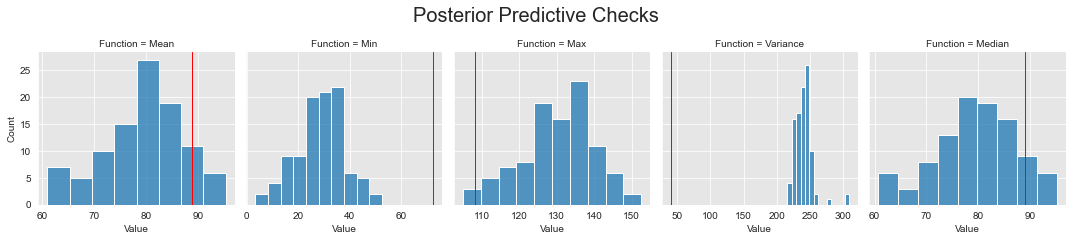

In [68]:
max_plots = MaxModelPlots(max_model.X_train,max_model.X_val,max_model.y_train,max_model.y_val,max_model.L,vb)
max_plots.posterior_predictive_checks()

As seen above, I compared the mean, minmum, maximum, variance and median of the predictive posterior to the true value (the red line). As seen above, the model does not fit the data very well. Specifically, it seems, while the mean and median are acceptable, the minimum, maximum and variance of the model are off. I hypothesize this is due to the inherent issue of the indepdent variables not explaining much of the variation in the temperature of the sensors. Unlike the observations made in the paper, which used satellite imagery, temperature sensors are suceptible to a myriad of environmental factors which are not measured in the dataset I created. Some variables of such variables could be: cloud coverage, shade, and sensor accuracy.

In [69]:
print('MSE:',max_plots.mse())

MSE: 491.0854859638864


In terms of model evaluation, I left out 20% of the data as an evaluation set. A full cross-validation could not be done in the time constraints; however, it would be a next step to more accurately estimate the mean squared error of the model. As seen above, the model has an MSE of 491, which is fairly high. 

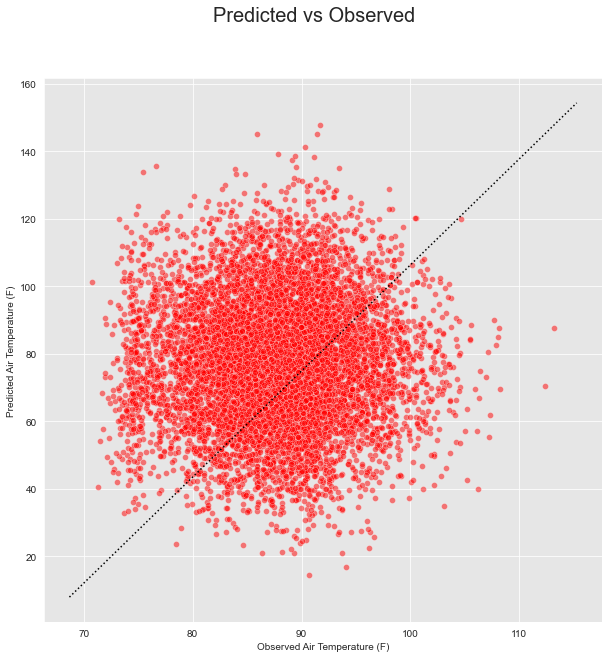

In [70]:
max_plots.predicted_v_observed()

As seen above I have plotted the Observed Air Temperature against the Predicted Temperature from the model. The closer the points are to the $y=x$ axis, the better the predictions. This graph is helpful in order to see whether the model is particularly better at predicting certain ranges of temperatures. 

As seen above, this model fits the data quite poorly, and hence it is clear that the coefficients of this model will not be representitive of the causal effect of the factors of the UHI effect on the maximum daily temperatures.

In [74]:
del max_model # Need to free up memory :)
del vb
del max_plots

## Averaged 24 Hour Model

#### Modeling
For a second iteration on Box's loop, I wanted to add more complexity to the model to see if we could fit the data better. Specifically, I wanted to model the temperatures throughout the day as a Time Series with time-varying coefficients (by hour). This, could allow the model to have different weightings on the factors of UHI throughout the day. We get the following model specification:

$$y_t = x \beta_t + \epsilon_t$$

$$\beta_{t+1} = \beta_t + \eta_t$$

Where $y_t$ represents the recorded temperature at hour $t$ of the day and $X$ represents the variables at the location corresponding to the temperature $y_t$. $\epsilon_t \sim$ InvGamma$(1,1)$, $\eta_t~ \sim N(0,1)$, where. I define $\beta_1 ~ N(0,1)$. 

We would expect to see areas with a large amount of trees to have negative coefficients throughout the day, as a tree canopy can provide shade during the hottest hours of the day. We would also expect variables that are a function of density, such as **num_build500**, to have a postive effect on temperature throughout the night, as cement (and thus density), traps heat during the day and slowly release the heat throughout the night.

In [71]:
m = AvgModel('models/24h_model.stan','data/avg_model_data.h5')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/sotiriskaragounis/git/UHInyc/models/24h_model


#### Inference

This model takes quite a bit of time to fit, both for MCMC and for variational inference. In the many tests and trials that I have done with both, I found that ADVI results in a model with exceptionally high variance. Hence, I have opted to use MCMC, which while more time consuming to run, provides much lower variance. I ran the MCMC with default settings for 1000 iterations and 4 chains.

In [75]:
mcmc = m.inference() # Careful! This takes ~3 hours to run

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


Below I have plotted the iterations against values of each of the time-varying coefficients. I wanted to see whether the chains have not gotten stuck at certain anomalies. Furthermore, I wanted to see how much variance certain variables had. As seen below the **bias** and **is_august** seem to have high variance. 

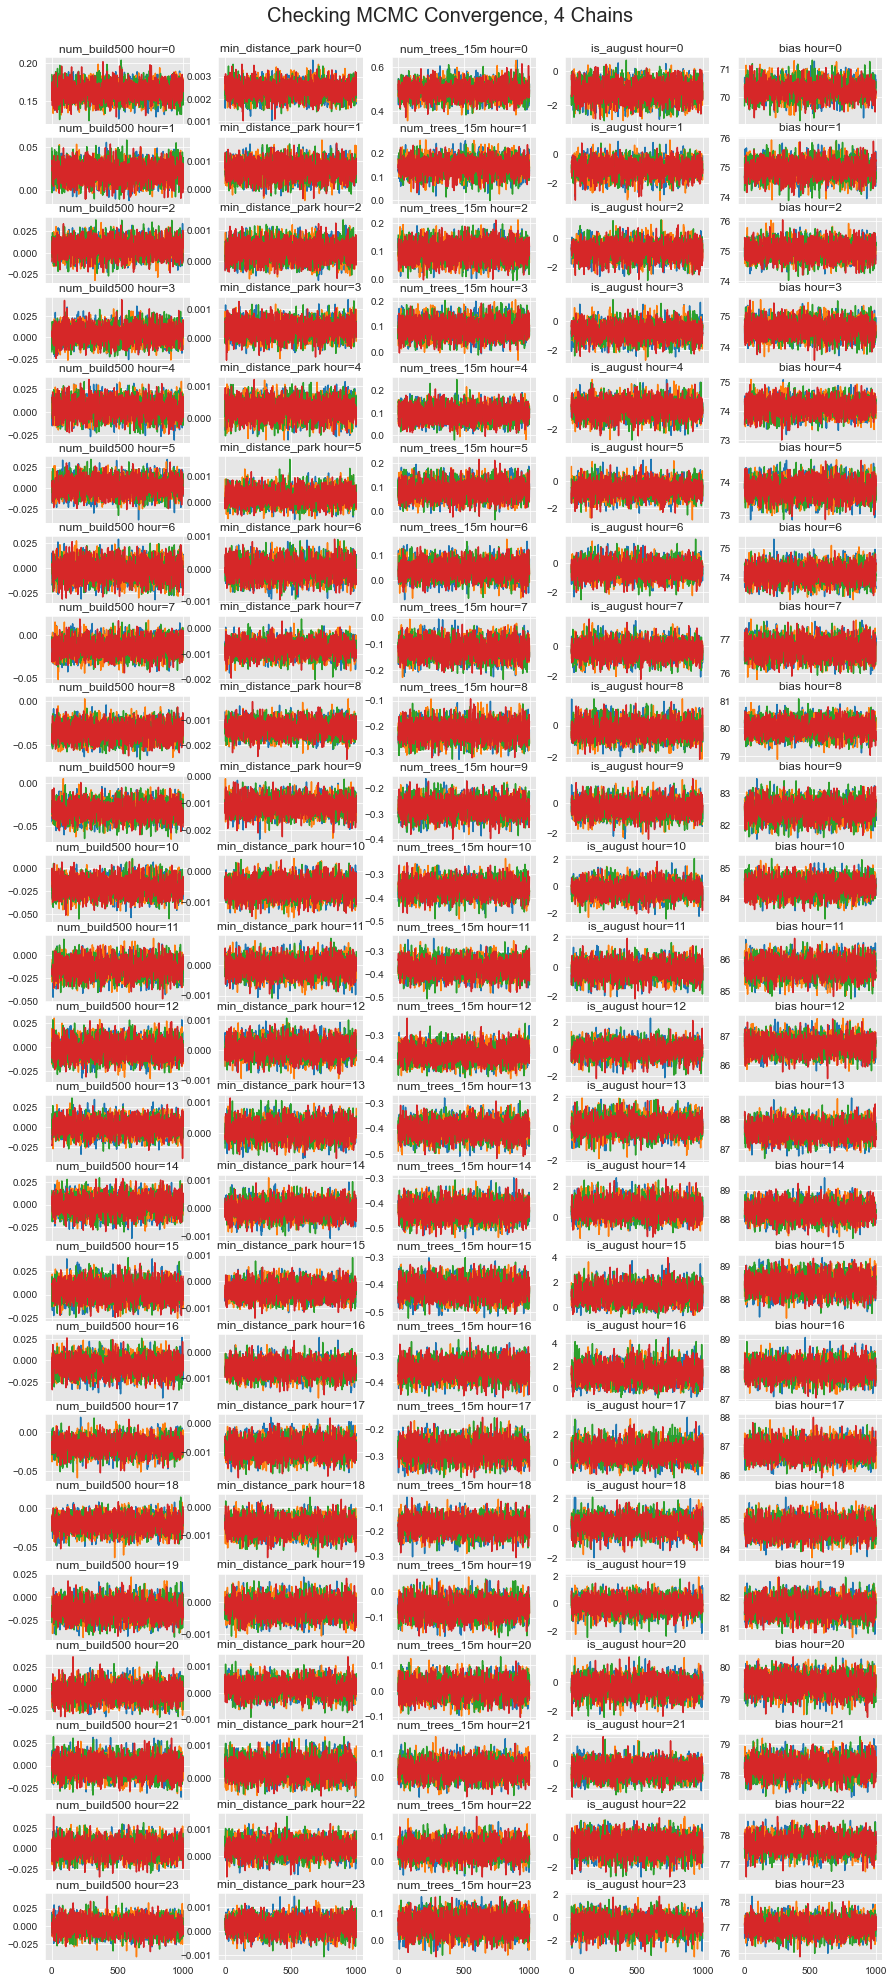

In [83]:
a = AvgModelPlots(m.X_train,m.X_val,m.y_train,m.y_val,m.L,mcmc)
a.checking_mcmc_convergence()

I then wanted to plot the coefficients against time to see how their weight change throughout the day. Below are the sample means of the iterations from each of the chains from the MCMC and each of their confidence intervals. As seen below, the confidence intervals match for **num_build500**,**min_distance_park** and **num_trees_15m**, while the confidence intervals are larger for both **is_august** and the **bias** term.

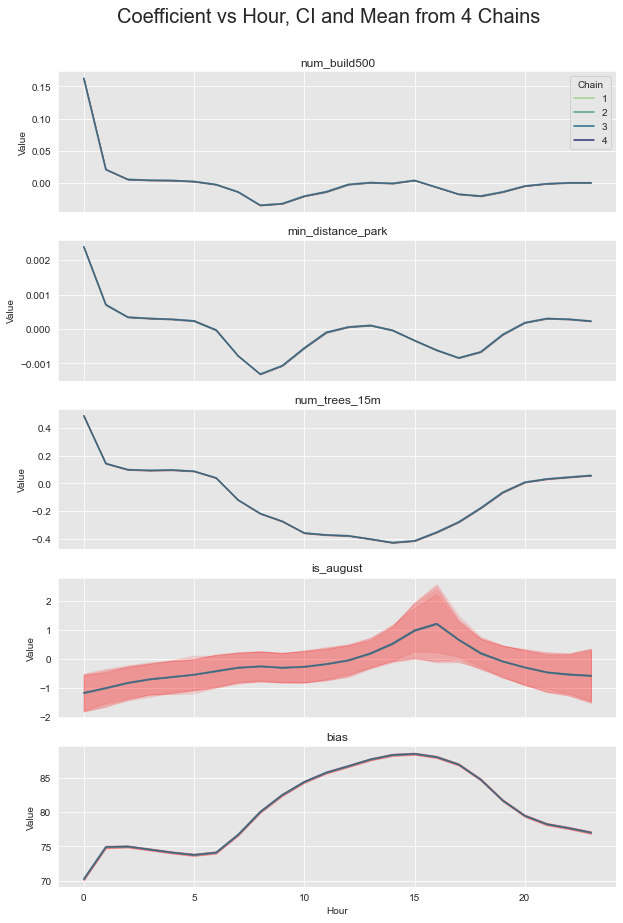

In [84]:
a.coefficient_v_hour()

#### Critisism

Unfortunately, this model suffers much of the same problems that the previous model had in that it has a significant amount of variance. Below are 5 samples from the posterior predictive and their 95% confidence intervals:

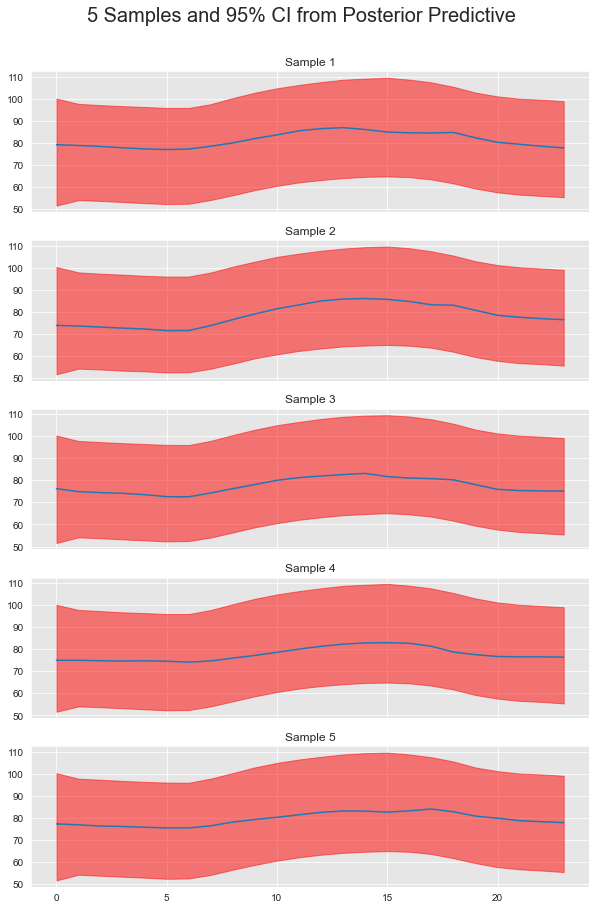

In [85]:
a.samples_from_posterior_predictive()

I wanted to do some postierior predictive checks to see how the model fits different aspects of the data. Below are the distributions of the aggregate functions at each hour of the day, with the red line being the true value of a specific aggregate function. As seen below, once again the model is able to capture the mean and median values of temperatures at specific hours throughout the day; however, the model suffers from very high variance.

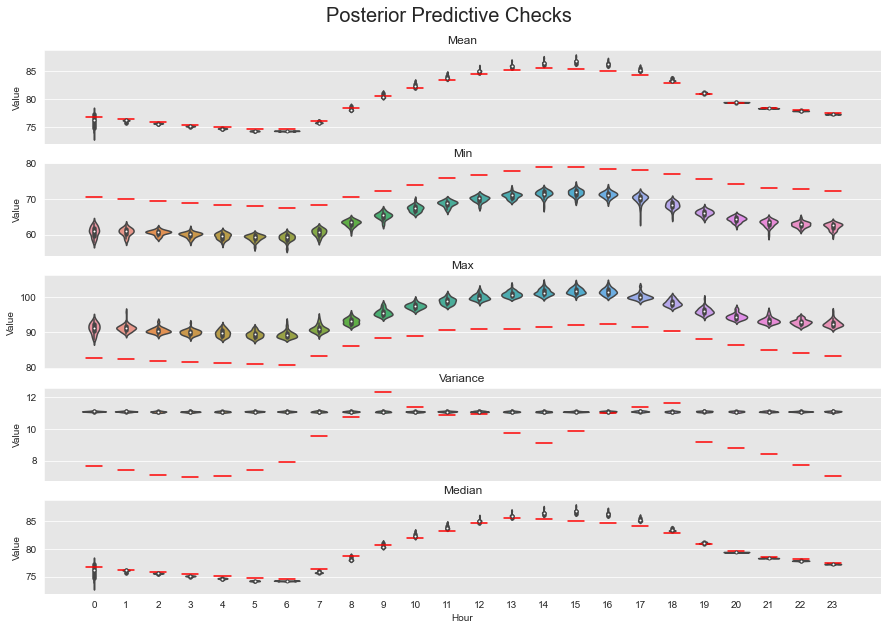

In [86]:
a.posterior_predictive_checks()

Lastly below is the MSE for each hour of the day. Interestingly, there is a high mean squared error at the first hour of the day. This may be due to the fact that the prior of the first $\beta$ comes from $\eta_1 \sim N(0,1)$, which is pretty uniformative. I have tried perturbing the priors, as well as changing the distribution; however, I was not able to lower the variation in the model itself.

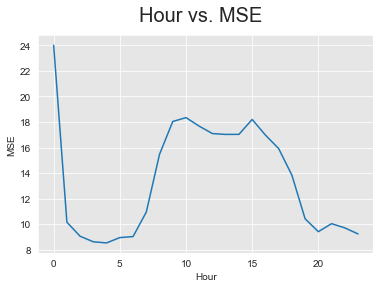

In [88]:
a.hour_v_mse()

In [89]:
del mcmc 